This is the version based on https://heartbeat.comet.ml/build-train-and-deploy-a-book-recommender-system-using-keras-tensorflow-js-b96944b936a7

In [1]:
#import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [2]:
#import the dataset

ratings_df = pd.read_csv("final_ratings_new_ver.csv", encoding="latin-1")
resto_df = pd.read_csv("Restaurant_list_new_ver.csv", encoding="latin-1")
ratings_df.head()

,userID,placeID,rating
0,1001,1,4
1,1002,1,5
2,1003,1,4
3,1004,1,3
4,1005,1,5


In [3]:
#Let's see the rating dataset

print(ratings_df.shape)
print(ratings_df.userID.nunique())
print(ratings_df.placeID.nunique())
ratings_df.isna().sum()

(765, 3)
136
18


userID     0
placeID    0
rating     0
dtype: int64

In [4]:
#split the data to training (90%) and test (10%)

from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.1, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (688, 3)
Shape of test data: (77, 3)


In [5]:
#Get the number of unique entities in resto and users columns

n_placeID = ratings_df.placeID.nunique()
n_userID = ratings_df.userID.nunique()

In [6]:
#embedding process

#resto input network
input_resto = tf.layers.Input(shape=[1])
embed_resto = tf.layers.Embedding(n_placeID + 1500,100)(input_resto)
resto_out = tf.layers.Flatten()(embed_resto)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(n_userID + 1500,100)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([resto_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_resto, input_users], x_out)

In [8]:
#choosing optimizer and loss function

opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       151800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 100)       163600      ['input_2[0][0]']                
                                                                                              

In [9]:
#Train the model

hist = model.fit([Xtrain.placeID, Xtrain.userID], Xtrain.rating, 
                 batch_size=64, 
                 epochs=5, 
                 verbose=1,
                 validation_data=([Xtest.placeID, Xtest.userID], Xtest.rating))

Epoch 1/5
11/11 [==============================] - 1s 18ms/step - loss: 19.4199 - val_loss: 19.3994
Epoch 2/5
11/11 [==============================] - 0s 6ms/step - loss: 17.0768 - val_loss: 16.1569
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 12.6240 - val_loss: 10.0176
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 5.8909 - val_loss: 2.8709
Epoch 5/5
11/11 [==============================] - 0s 7ms/step - loss: 1.3084 - val_loss: 0.8071


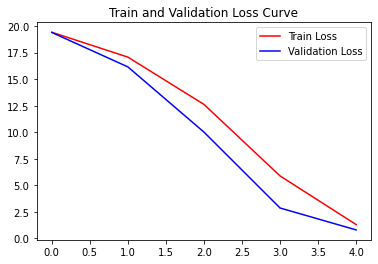

In [10]:
#plotting the losses

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [11]:
#save the model

model.save('model')

INFO:tensorflow:Assets written to: model\assets


In [69]:
# tf.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [78]:
#Extract embeddings

resto_em = model.get_layer('embedding')
resto_em_weights = resto_em.get_weights()[0]
resto_em_weights.shape

ValueError: No such layer: embedding. Existing layers are: ['input_31', 'input_32', 'embedding_28', 'embedding_29', 'flatten_28', 'flatten_29', 'concatenate_14', 'dense_28', 'dense_29'].

In [12]:
#getting restaurant's name

resto_df_copy = resto_df.copy()
resto_df_copy = resto_df_copy.set_index("placeID")

In [13]:
#making tsv file

r_id =list(ratings_df.placeID.unique())
#r_id.remove(10000)
dict_map = {}
for i in r_id:
    dict_map[i] = resto_df_copy.iloc[i]['Nama_resto']
    
out_v = open('vecs.tsv', 'w')
out_m = open('meta.tsv', 'w')
for i in r_id:
    resto = dict_map[i]
    embeddings = resto_em_weights[i]
    out_m.write(resto + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

KeyError: 'Nama_resto'

In [15]:
#Making recommendations for user U1025

resto_arr = np.array(r_id) #get all resto IDs
user = np.array([25 for i in range(len(r_id))])
pred = model.predict([resto_arr, user])
pred

1/1 [==============================] - 0s 83ms/step


array([[2.8373702],
       [3.1699944],
       [2.789134 ],
       [3.3922906],
       [2.8055863],
       [3.068725 ],
       [3.0518537],
       [3.0350513],
       [2.6537886],
       [3.366106 ],
       [3.160396 ],
       [2.785738 ],
       [2.9335747],
       [3.2571445],
       [3.3272924],
       [3.1285434],
       [2.7159276],
       [2.7752109]], dtype=float32)

In [16]:
#retrival process (top 10)

pred = pred.reshape(-1) #reshape to single dimension
pred_ids = (-pred).argsort()[0:10]
pred_ids

array([ 3,  9, 14, 13,  1, 10, 15,  5,  6,  7], dtype=int64)

In [17]:
#getting the top 10 restos data

resto_df.iloc[pred_ids]

,placeID,Nama_resto
3,4,Dusun Bambu
9,10,Miss Bee Providore
14,15,The Valley
13,14,The Stone Café
1,2,Braga Permai Resto
10,11,Raja Rasa
15,16,Tizi's
5,6,Hummingbird Eatery
6,7,Kampung Daun
7,8,Karnivor
